In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import TrashIm

In [2]:
# input one from the project
input_ms = np.load('RawMSCapstone.npy')

In [3]:
# input two from the project
matchedThermal = np.load('matchedThermalCapstone.npy')

22.248013215906433


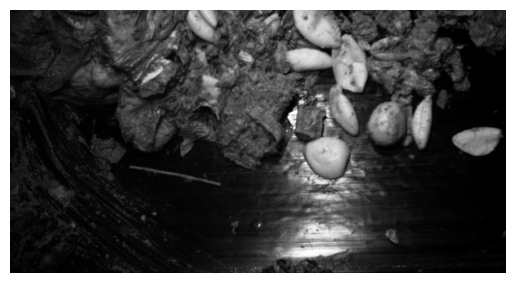

In [52]:
# this can be displayed in the streamlit application once input_one is uploaded
histo = TrashIm.image_histogram_equalization(input_ms,30)
hist = histo[0]
plt.imshow(hist,'gray')
plt.axis("off")
print(np.min(hist))

In [30]:
# these files need to be loaded
#1. Flatfield Correction
dark = (np.load('utilImages\\darkmosaic.npy') +np.load('utilImages\\darkmosaic1.npy') +
        np.load('utilImages\\darkmosaic2.npy')) / 3.0
light = np.load('utilImages\\12_07_dfield.npy')

#Calibration Plate
calCurve0 = np.load('utilImages\\calCurve.npy')

#Cross talk correction and demosaic/downsample
c0 = np.load('utilImages\\correction0.npy')
c1 = np.load('utilImages\\correction1.npy')
correction = c0+c1
correction = correction/2.0

#Homography matrix
H = np.load('CamMatrices\\HomographyTherm2.npy')
H1 = np.load('CamMatrices\\HomographyColor.npy')

In [53]:
# flatfield correction

#ffieldIm =inputIm.copy()# TrashIm.ffield(inputIm,light,dark)

# This function can be used in streamlit
def generate_image_mosiac(input_file, light, dark):
    # flat field correction
    ffieldIm = TrashIm.ffield(input_ms,light,dark)
    bands = [609.0, 625.6, 648.0, 666.3, 683.9, 700.8, 718.9, 736.6, 754.1, 770.1, 786.2, 802.4, 818.3, 833.1, 849.4]
    # interpolate
    wb = TrashIm.interp(ffieldIm)
    # calibration and correction
    imageMosaic = wb.copy()
    test = np.dot(imageMosaic,correction.T)
    imageMosaic = test/calCurve0
    return imageMosaic


In [54]:
im_mosiac = generate_image_mosiac(input_ms, light, dark)

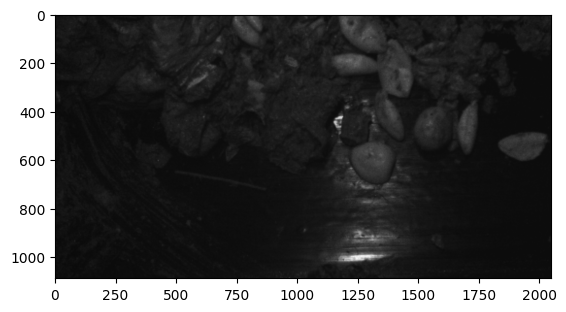

In [55]:
plt.imshow(im_mosiac[:,:,0],'gray')

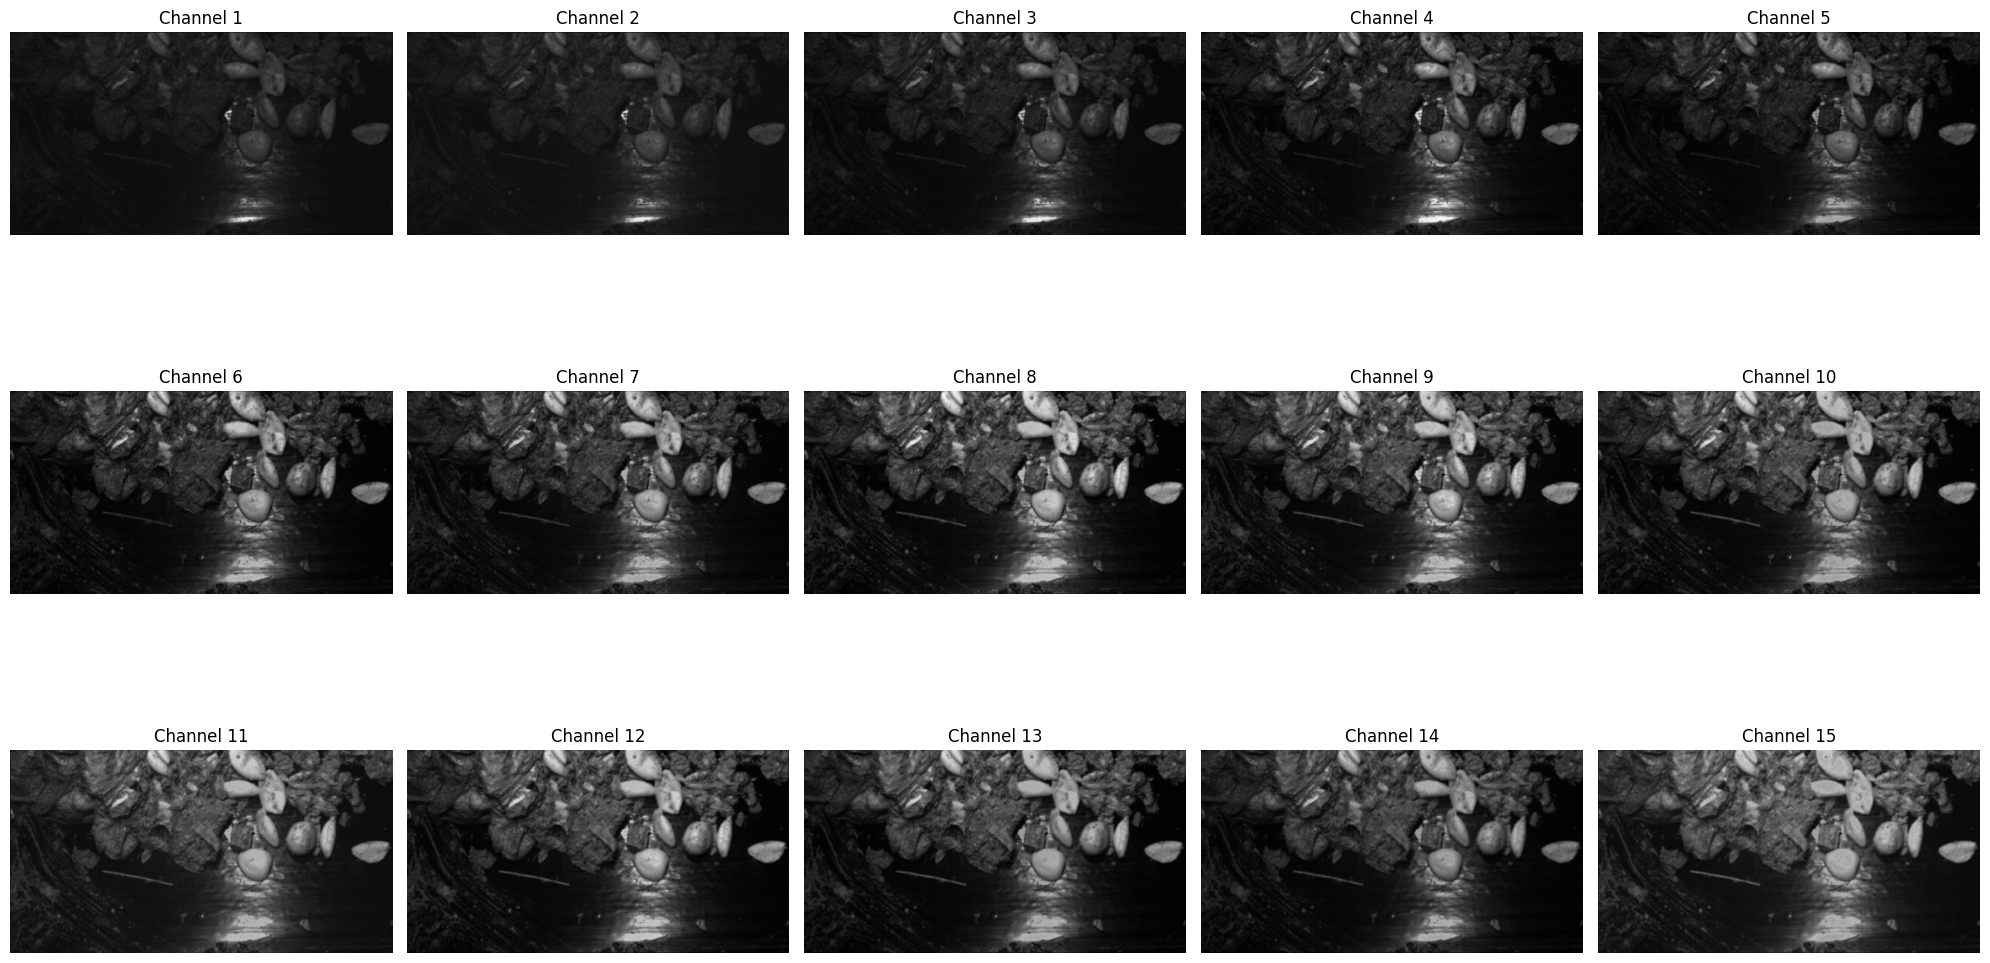

In [57]:
# visualilze all the 15 channels of the image mosiac
# Number of rows and columns for the subplot grid
nrows = 3
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))

for i in range(nrows):
    for j in range(ncols):
        # Calculate the index of the current channel
        channel_index = i * ncols + j
        if channel_index < im_mosiac.shape[2]:
            ax = axes[i, j]
            # Plotting the channel data
            ax.imshow(im_mosiac[:, :, channel_index], cmap='gray')
            ax.axis('off')  # Turn off axis for cleaner visualization
            ax.set_title(f'Channel {channel_index+1}')

plt.tight_layout()
plt.show()

In [29]:
# input wto
therm = matchedThermal.copy()

In [58]:
new = np.reshape(therm, (therm.shape[0], therm.shape[1],1))

In [63]:
print(new.shape)
therm.shape

(512, 640, 1)


(512, 640)

In [64]:
# this function needs to be added to streamlit as well
def combine_mosiac_and_therm(image_mosiac, therm):
    therm = np.reshape(therm, (therm.shape[0], therm.shape[1],1))
    dstMS, dstTH,dstC = TrashIm.undistort(image_mosiac,therm,color=0)
    imwarp = TrashIm.applyHom(dstTH,H,dstMS.shape[1],dstMS.shape[0])
    fullIm = TrashIm.stack(dstMS,imwarp)
    return fullIm


In [66]:
# this file needs to be downloaded
fullIm = combine_mosiac_and_therm(im_mosiac, therm)

In [67]:
spectral = fullIm[:,:,:-1]
print(fullIm.shape)

(1049, 2021, 16)


In [68]:
spectral.shape

(1049, 2021, 15)

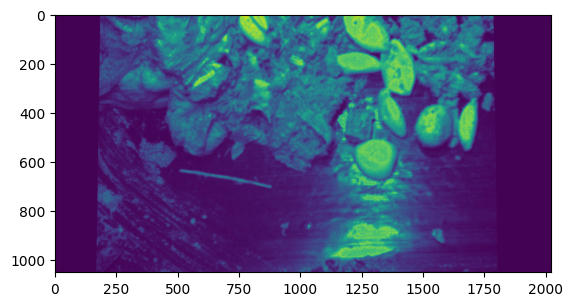

In [69]:
plt.imshow(fullIm[:,:,14])